In [1]:
# Environment Variables: 

YES = 1
NO = 0

# Google Drive:
using_google_drive = NO

if using_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf
import hls4ml

# %matplotlib inline
output_scaler = StandardScaler()
print(tf.config.list_physical_devices('GPU'))

np.random.seed(0)
tf.random.set_seed(0)

2024-12-05 13:15:53.593073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 13:15:53.676602: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 13:15:53.679449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-05 13:15:53.679467: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

[]


2024-12-05 13:15:56.334921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 13:15:56.335134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-05 13:15:56.335241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-05 13:15:56.335310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-05 13:15:56.335374: W tensorf

# To load data

In [3]:
JUST_SAMPLE = YES
# Read H5 Data File:
DATA_DIR = 'data' # Change to your DATA PATH

RHEED_DATA_FILE = DATA_DIR + '/RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)

if JUST_SAMPLE:
    normalized_images = normalized_images[:10, :, :]

print(f'[Normalized Images Shape]: {normalized_images.shape}')

[Normalized Images Shape]: (10, 48, 48)


[Normalized Image #5]:


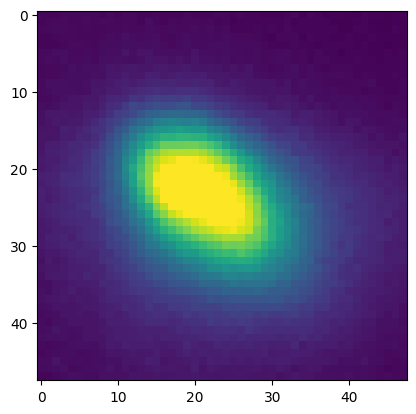

In [4]:
# Validate Data Array:
validate_data_array = YES

if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

In [5]:
# Functions for estimating labels

# generate 2d Gaussian from its parameters
# x, y = x-coord, y-coord
# A = amplitude
# x0, y0 = mean-x, mean-y
# sigma_x, sigma_y = std.-dev.-x, std.-dev.-y
def gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y):
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Initial guess for each parameter
# data = normalized image
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Compute residuals
# params = A, x0, y0, sigma_x, sigma_y
# x, y  = x-coord, y-coord
# data = normalized image
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

# Convert parameters from A, x0, y0, sigma_x, sigma_y --> mean_x, mean_y, cov_x, cov_y, theta
# params = A, x0, y0, sigma_x, sigma_y
def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

@delayed
def fit_gaussian_2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x


In [6]:
# Estimate Labels:
load_labels = YES # (Takes <1 min to load, ~40 mins to generate)

# Import From File
if load_labels:
    file_path = ''
    # estimated_labels = np.load(file_path)
    estimated_labels = np.random.rand(normalized_images.shape[0], 5)

# Generate
else:
    estimated_labels = []
    with Client() as client:
        guesses = [add_guess(image) for image in normalized_images]
        fits = [fit_gaussian_2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
        estimated_labels = [convert_parameters(params) for params in compute(*fits)]
    estimated_labels = np.array(estimated_labels).astype(np.float32)

if JUST_SAMPLE:
    estimated_labels = estimated_labels[:10]
print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (10, 5)


In [7]:
# Create DataSet:
batch_size = 1000

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(normalized_images)
    dataset = dataset.shuffle(normalized_images.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

output_scaler.fit(estimated_labels)

2024-12-05 13:15:58.965283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


StandardScaler()

In [8]:
for i, img in enumerate(dataset):
    if i>=1:
        continue
    print(img.shape)

(10, 48, 48)


In [9]:
# Gaussian Function: (TENSORFLOW)
print_example_guassian = NO

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=1)

if print_example_guassian:
    image_shape = (48, 48)
    batch = tf.convert_to_tensor([
        [21.8558168, 24.50041009, 10.31268177, 9.1700225, 0.72681534]
        , [21.76068143, 24.37956637, 10.30043488, 9.15426013, 0.72655111]
        , [21.72363929, 24.31050759, 10.33800891, 9.18570812, 0.72644599]
        , [21.72777699, 24.29306623, 10.30178808, 9.14728058, 0.72610718]
        , [21.79849472, 24.34649405, 10.32683150, 9.16259293, 0.72573213]
    ])
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()

In [10]:
# Custom Loss Function (TENSORFLOW):
print_example_loss = YES

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_loss:
  I = tf.random.normal((5, 1, 48, 48))
  J = tf.random.normal((5, 1, 48, 48))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

[Custom Weighted MSE Loss]: 4.103805


 # 1. Train and convert just the Gaussian predictor

In [11]:
model2 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=98, activation='relu'),
        tf.keras.layers.Dense(units=5, activation='softmax')
    ]
)

model2.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [12]:
# Training Loop
train_model = NO
save_model = YES
load_model = YES

if train_model:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model2(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model2.trainable_variables)
            optimizer.apply_gradients(zip(grads, model2.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model2.save("GaussianModel2.keras")

if load_model:
    pass

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 re_lu (ReLU)                (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 6)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 726)               0         
                                                                 
 dense (Dense)               (None, 98)                71246     
                                                                 
 dense_1 (Dense)             (None, 5)                 495       
                                                        

In [13]:
# Generate the configuration from the Keras model
config2 = hls4ml.utils.config_from_keras_model(model2)

# Print out the config to debug and check for unwanted settings
print(config2)

# Attempt conversion on simplified model
hls_model2 = hls4ml.converters.convert_from_keras_model(
    model2, hls_config=config2, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e', io_type="io_stream"
)

Interpreting Sequential
Topology:
Layer name: conv2d_input, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: re_lu, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 11, 11, 6]], output shape: [None, 726]
Layer name: dense, layer type: Dense, input shapes: [[None, 726]], output shape: [None, 98]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 98]], output shape: [None, 5]
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: conv2d_input, layer type: InputLayer,

model2: Compare keras vs hls4ml

In [14]:
kpred_model2 = model2(normalized_images[:10]).numpy()

hls_model2.compile()
hpred_model2 = hls_model2.predict(np.ascontiguousarray(normalized_images[:10]))

print(np.abs(kpred_model2 - hpred_model2))

Writing HLS project
Done
self.inputs: ['conv2d_input']
[[1.8537045e-05 7.7702105e-04 3.6774576e-04 1.5980005e-04 2.6807189e-05]
 [1.2849271e-04 7.1865320e-04 2.6655197e-04 1.9849837e-04 6.1377883e-05]
 [1.3148785e-04 5.7402253e-04 3.0109286e-04 9.4413757e-05 6.4477324e-05]
 [1.3644993e-04 7.0856512e-04 4.2541325e-04 2.3730099e-04 5.6505203e-05]
 [1.6203523e-04 5.4600835e-04 3.7378073e-04 1.1356175e-04 8.2850456e-06]
 [1.4153123e-04 8.9813769e-04 2.8681755e-04 3.5624206e-04 6.3925982e-06]
 [1.6926229e-04 6.9484115e-04 2.2692978e-04 1.7565489e-04 6.1154366e-05]
 [7.8722835e-05 7.4240565e-04 3.4368038e-04 2.2156537e-04 3.3348799e-05]
 [8.3506107e-05 8.6088479e-04 3.2891333e-04 3.0800700e-04 1.1280179e-05]
 [1.1616945e-04 7.6885521e-04 2.5892258e-04 2.0791590e-04 4.0546060e-05]]


In [15]:
# hls_model2.build(csim=0)

# Train and convert the Gaussian predictor but with a CropLayer on top

In [16]:
from pathlib import Path
from tensorflow.keras import layers
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import Attribute

IMAGE_SIZE = (100, 160)
NUM_BLOBS = 1
CROP_BOX_ROWS = 48
CROP_BOX_COLS = 48
CROP_SHAPE = normalized_images.shape[1:]

In [17]:
class CropLayer(layers.Layer):
    def __init__(self, image_shape, crop_shape, num_boxes, **kwargs):
        super(CropLayer, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.crop_shape = crop_shape
        self.num_boxes = num_boxes

    def call(self, inputs):
        image = inputs
        batch_size = tf.shape(image)[0]

        crop_boxes_hc = tf.convert_to_tensor(np.array([[0.38787913, 0.37316015, 0.86787915, 0.67316014]], dtype=np.float32))
        crop_boxes = tf.repeat(crop_boxes_hc, batch_size)
        
        crop_boxes = tf.reshape(crop_boxes, (batch_size * self.num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=self.num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, self.crop_shape
        )
        # cropped_images = tf.squeeze(cropped_images)
        
        return cropped_images
    
    def get_config(self):
        # Breaks serialization and parsing in hls4ml if not defined
        return super().get_config()

In [18]:
def parse_crop_layer(keras_layer, input_names, input_shapes, data_reader):
    print(f"input_names = {input_names}")
    print(f"input_shapes = {input_shapes}")
    
    assert 'CropLayer' in keras_layer['class_name']
    
    crop_shape = None
    for l in data_reader.model.layers:
        print(f"\n l: {l}, \n l.__dict__: {l.__dict__} \n")
        try:
            # if l.name == keras_layer['name']:
            if isinstance(l, CropLayer): # TODO: Messy
                print(f"l{l}")
                crop_shape = l.crop_shape
        except KeyError:
            pass
    if crop_shape is None:
        raise AttributeError(f"Could not find crop_shape attribute for layer {keras_layer['name']}")

    layer = parse_default_keras_layer(keras_layer, input_names)
    img_shape = input_shapes[0]

    num_boxes = NUM_BLOBS
    num_channels = img_shape[-1]
    output_shape = [None, num_boxes, crop_shape[0], crop_shape[1], num_channels]

    layer["num_boxes"] = num_boxes
    layer["num_channels"] = num_channels
    layer["img_shape"] = img_shape
    max_idx = np.multiply(np.multiply(img_shape[1], img_shape[2]), img_shape[3])
    layer["idx_t"] = f"ap_uint<{int(np.ceil(np.log2(max_idx)) + 1)}>"

    return layer, output_shape

class HCropLayer(hls4ml.model.layers.Layer):
    "hls4ml implementation of the CropLayer"
    _expected_attributes = [Attribute('crop_rows'), Attribute('crop_cols')]

    def initialize(self):
        inp_0 = self.model.get_layer_output_variable(self.inputs[0]) # Image

        crop_shape = None
        for l in self.model.config.config['KerasModel'].layers:
            if l.name == self.get_attr('name'):
                crop_shape = l.crop_shape
        if crop_shape is None:
            raise AttributeError(f"Could not find crop_shape attribute for layer {self.get_attr('name')}")
        else:
            self.set_attr('crop_rows', crop_shape[0])
            self.set_attr('crop_cols', crop_shape[1])

        num_channels = inp_0.shape[-1]
        num_channels_name = inp_0.dim_names[-1]
        num_boxes = NUM_BLOBS
        num_boxes_name = "NUM_BOXES"

        crop_rows = self.get_attr('crop_rows')
        crop_cols = self.get_attr('crop_cols')

        shape = [num_boxes, crop_rows, crop_cols, num_channels]
        dim_names = [num_boxes_name, f"CROP_ROWS_{self.index}", f"CROP_COLS_{self.index}", num_channels_name]
        self.add_output_variable(shape, dim_names)

hls4ml.converters.register_keras_layer_handler('CropLayer', parse_crop_layer)
hls4ml.model.layers.register_layer('CropLayer', HCropLayer)

# Templates
crop_config_template = """struct config{index} : nnet::crop_config {{
    static const unsigned in_height = {in_height};
    static const unsigned in_width = {in_width};
    static const unsigned n_chan = {n_chan};
    static const unsigned n_crop_boxes = {n_crop_boxes};
    static const unsigned crop_rows = {crop_rows};
    static const unsigned crop_cols = {crop_cols};
\\
}};\n"""

crop_function_template = "nnet::crop<{input1_t}, {index_t}, {output_t}, {config}>({input1}, {output});"

crop_include_list = ["nnet_utils/nnet_crop.h"]

class HCropLayerConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HCropLayer)
        self.template = crop_config_template

    def format(self, node):
        params = self._default_config_params(node)

        image_input = node.get_input_variable(node.inputs[0])
        params['in_height'] = image_input.shape[0]
        params['in_width'] = image_input.shape[1]
        params['n_chan'] = image_input.shape[2]

        # crop_coords_input = node.get_input_variable(node.inputs[1])
        params['n_crop_boxes'] = NUM_BLOBS
        params['crop_rows'] = CROP_BOX_ROWS
        params['crop_cols'] = CROP_BOX_COLS
        return self.template.format(**params)
    
class HCropLayerFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    def __init__(self):
        super().__init__(HCropLayer, include_header=crop_include_list)
        self.template = crop_function_template

    def format(self, node):
        
        params = {}
        params['config'] = f'config{node.index}'
        params['input1_t'] = node.get_input_variable(node.inputs[0]).type.name
        params['output_t'] = node.get_output_variable().type.name
        params['input1'] = node.get_input_variable(node.inputs[0]).name
        params['output'] = node.get_output_variable().name

        image_input = node.get_input_variable(node.inputs[0])
        in_height = image_input.shape[0]
        in_width = image_input.shape[1]
        n_chan = image_input.shape[2]
        max_idx = in_height*in_width*n_chan
        params['index_t'] = f'ap_uint<{int(np.ceil(np.log2(max_idx)))}>'

        return self.template.format(**params)
    
backend = hls4ml.backends.get_backend('Vivado')
backend.register_template(HCropLayerConfigTemplate)
backend.register_template(HCropLayerFunctionTemplate)
p = Path("nnet_crop.h")
backend.register_source(p)

In [55]:
import copy
crop_coords_hard = np.array([0.38787913, 0.37316015, 0.86787915, 0.67316014], dtype=np.float32)

y1 = int(crop_coords_hard[0]*IMAGE_SIZE[0])
x1 = int(crop_coords_hard[1]*IMAGE_SIZE[1])
y2 = int(crop_coords_hard[2]*IMAGE_SIZE[0])
x2 = int(crop_coords_hard[3]*IMAGE_SIZE[1])

padded_normalized_images = np.random.rand(normalized_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1])
padded_normalized_images[:, y1:y2, x1:x2] = copy.deepcopy(normalized_images)

In [56]:
# Create DataSet:
batch_size = 1000
padded_normalized_images = padded_normalized_images[:int(1e5)] # memory issues

with tf.device('CPU'):
    padded_dataset = tf.data.Dataset.from_tensor_slices(padded_normalized_images[:int(5e5)])
    padded_dataset = padded_dataset.shuffle(padded_normalized_images.shape[0], reshuffle_each_iteration=True)
    padded_dataset = padded_dataset.batch(batch_size)

if not JUST_SAMPLE:
    del normalized_images # memory issues

In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# def build_model_w_crop(image_shape, crop_size, num_boxes):
#     inputs = layers.Input(shape=image_shape)
#     x = CropLayer(image_shape, crop_size, num_boxes)(inputs)
#     x = layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid')(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPool2D(pool_size=4, strides=4)(x)

#     x = layers.Flatten()(x)
#     x = layers.Dense(units=98, activation='relu')(x)
#     x = layers.Dense(units=5, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=x)

#     return model

# model2_wcrop = build_model_w_crop(IMAGE_SIZE, CROP_SHAPE, 1)

model2_wcrop = tf.keras.Sequential(
    [
        CropLayer(image_shape = IMAGE_SIZE, crop_shape = CROP_SHAPE, num_boxes = 1, batch_input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=98, activation='relu'),
        tf.keras.layers.Dense(units=5, activation='softmax')
    ]
)

model2_wcrop.compile(optimizer='adam', loss=custom_weighted_mse_loss)

ValueError: Exception encountered when calling layer "crop_layer_2" (type CropLayer).

in user code:

    File "/tmp/ipykernel_11833/1863392085.py", line 19, in call  *
        cropped_images = tf.image.crop_and_resize(

    ValueError: Shape must be rank 4 but is rank 3 for '{{node crop_layer_2/CropAndResize}} = CropAndResize[T=DT_FLOAT, extrapolation_value=0, method="bilinear"](Placeholder, crop_layer_2/Reshape_1, crop_layer_2/Repeat_1/Reshape_1, crop_layer_2/CropAndResize/crop_size)' with input shapes: [?,100,160], [?,4], [?], [2].


Call arguments received by layer "crop_layer_2" (type CropLayer):
  • inputs=tf.Tensor(shape=(None, 100, 160), dtype=float32)

In [58]:
for i, img in enumerate(padded_dataset):
    if i>=1: 
        continue
    print(img.shape)

(10, 100, 160)


In [59]:
# Training Loop
train_model = YES
save_model = YES
load_model = NO

if train_model:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(padded_dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model2_wcrop(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                print(f"image_batch.shape: {image_batch.shape}")
                print(f"final.shape: {final.shape}")
                unpadded_image_batch = image_batch[:, y1:y2, x1:x2, :]
                loss = custom_weighted_mse_loss(unpadded_image_batch, final, n)
            grads = tape.gradient(loss, model2_wcrop.trainable_variables)
            optimizer.apply_gradients(zip(grads, model2_wcrop.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model2_wcrop.save("GaussianModel2_wcrop.keras")

if load_model:
    pass

model2_wcrop.summary()

  0%|          | 0/1 [00:00<?, ?it/s]


image_batch.shape: (10, 100, 160, 1)
final.shape: (10, 1, 48, 48)


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Sub]

In [60]:
# Generate the configuration from the Keras model
config2_wcrop = hls4ml.utils.config_from_keras_model(model2_wcrop)
config2_wcrop['Model']['Precision']['default'] = 'ap_fixed<32,8>'

# Print out the config to debug and check for unwanted settings
# print(config2_wcrop)

# Attempt conversion on simplified model
hls_model2_wcrop = hls4ml.converters.convert_from_keras_model(model2_wcrop, 
                                                              hls_config=config2_wcrop, 
                                                              output_dir='model_2_wcrop/hls4ml_prj', 
                                                              part='xcu250-figd2104-2L-e', 
                                                              io_type="io_stream")

Interpreting Sequential
Topology:
Layer name: crop_layer_1_input, layer type: InputLayer, input shapes: [[None, 100, 160, 1]], output shape: [None, 100, 160, 1]
input_names = None
input_shapes = [[None, 100, 160, 1]]

 l: <__main__.CropLayer object at 0x7f89556c2830>, 
 l.__dict__: {'_self_setattr_tracking': True, '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping True>: 1, <_ObjectIdentityWrapper wrapping <keras.utils.generic_utils.Config object at 0x7f89556c2770>>: 1, <_ObjectIdentityWrapper wrapping (100, 160)>: 1, <_ObjectIdentityWrapper wrapping (48, 48)>: 1, <_ObjectIdentityWrapper wrapping 1>: 1}), '_auto_get_config': True, '_auto_config': <keras.utils.generic_utils.Config object at 0x7f89556c2770>, '_instrumented_keras_api': True, '_instrumented_keras_layer_class': True, '_instrumented_keras_model_class': False, '_trainable': True, '_stateful': False, 'built': True, '_input_spec': None, '_build_input_shape': TensorShape([None, 100, 160, 1])

model2_wcrop: Compare keras vs hls4ml

In [61]:
kpred_model2_wcrop = model2_wcrop(padded_normalized_images[:10]).numpy()

hls_model2_wcrop.compile()
hpred_model2_wcrop = hls_model2_wcrop.predict(np.ascontiguousarray(padded_normalized_images[:10]))

print(np.abs(kpred_model2_wcrop - hpred_model2_wcrop))

Writing HLS project
Done
self.inputs: ['crop_layer_1_input']
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
CONFIG_T::n_crop_boxes = 1
[[0.02122249 0.02377117 0.0792525  0.02728963 0.02510402]
 [0.02120832 0.02377418 0.07923357 0.02729173 0.02510022]
 [0.03670871 0.03281075 0.06776781 0.02677754 0.00768483]
 [0.00786443 0.02688424 0.06065318 0.02904536 0.02122016]
 [0.01457797 0.03352828 0.02540937 0.03081039 0.01329769]
 [0.01047763 0.02622874 0.06442186 0.02873938 0.02202608]
 [0.00437124 0.03027301 0.04210423 0.03021045 0.01713067]
 [0.02804829 0.04999101 0.01303571 0.04802513 0.01364242]
 [0.01148109 0.02598318 0.06585175 0.02861688 0.02232951]
 [0.0004628  0.02913177 0.04819608 0.02988821 0.01849493]]


For completeness' sake, to check if it's our data handling that caused the difference

In [62]:
kpred_model2_padded = model2(padded_normalized_images[:10, y1:y2, x1:x2]).numpy()

hpred_model2_padded = hls_model2.predict(np.ascontiguousarray(padded_normalized_images[:10, y1:y2, x1:x2]))

print(np.abs(kpred_model2_padded - hpred_model2_padded))

self.inputs: ['conv2d_input']
[[1.85370445e-05 7.77021050e-04 3.67745757e-04 1.59800053e-04
  2.68071890e-05]
 [1.28492713e-04 7.18653202e-04 2.66551971e-04 1.98498368e-04
  6.13778830e-05]
 [1.31487846e-04 5.74022532e-04 3.01092863e-04 9.44137573e-05
  6.44773245e-05]
 [1.36449933e-04 7.08565116e-04 4.25413251e-04 2.37300992e-04
  5.65052032e-05]
 [1.62035227e-04 5.46008348e-04 3.73780727e-04 1.13561749e-04
  8.28504562e-06]
 [1.41531229e-04 8.98137689e-04 2.86817551e-04 3.56242061e-04
  6.39259815e-06]
 [1.69262290e-04 6.94841146e-04 2.26929784e-04 1.75654888e-04
  6.11543655e-05]
 [7.87228346e-05 7.42405653e-04 3.43680382e-04 2.21565366e-04
  3.33487988e-05]
 [8.35061073e-05 8.60884786e-04 3.28913331e-04 3.08007002e-04
  1.12801790e-05]
 [1.16169453e-04 7.68855214e-04 2.58922577e-04 2.07915902e-04
  4.05460596e-05]]


# 4. Inspect discrepancy

In [ ]:
from keras import backend as K
# crop_layer = model2_wcrop.layers[0]
crop_layer = tf.keras.Sequential([CropLayer(image_shape = IMAGE_SIZE, crop_shape = CROP_SHAPE, num_boxes = 1, batch_input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))])
crop_layer.compile(optimizer='adam', loss=custom_weighted_mse_loss)
# crop_layer_func = K.function(model2_wcrop.inputs, crop_layer.output)

cropped_padded_normalized_images = crop_layer(padded_normalized_images)
crop_inacc = np.abs(tf.squeeze(cropped_padded_normalized_images)- normalized_images)


In [79]:
from keras import backend as K
crop_layer = model2_wcrop.layers[0]
crop_layer_func = K.function(model2_wcrop.inputs, crop_layer.output)

cropped_padded_normalized_images = crop_layer_func(padded_normalized_images).squeeze()
crop_inacc = np.abs(cropped_padded_normalized_images - normalized_images)


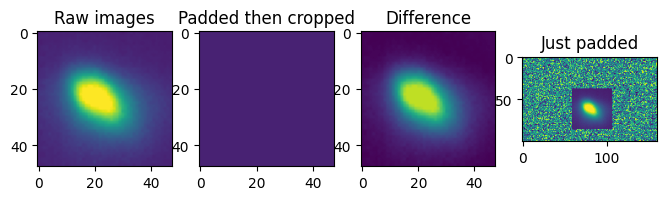

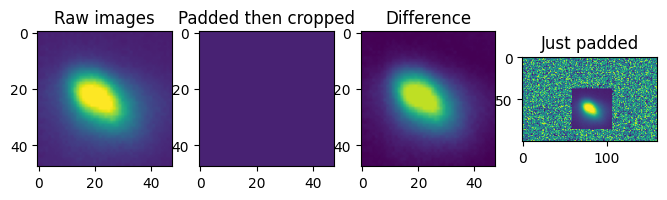

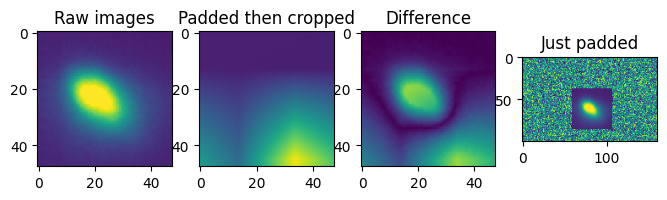

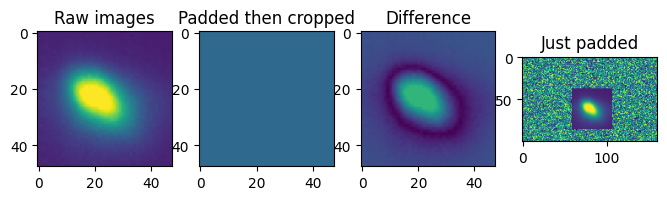

In [ ]:
for i in range(10):
    fig, axes = plt.subplots(1, 4, figsize=(8, 35))

    axes[0].imshow(normalized_images[i], vmin=0, vmax=1)
    axes[0].set_title("Raw images")

    axes[1].imshow(cropped_padded_normalized_images[i], vmin=0, vmax=1)
    axes[1].set_title("Padded then cropped")

    axes[2].imshow(crop_inacc[i], vmin=0, vmax=1)
    axes[2].set_title("Difference")

    axes[3].imshow(padded_normalized_images[i], vmin=0, vmax=1)
    axes[3].set_title("Just padded")

    plt.show(fig)
    plt.close(fig)


In [31]:
model2(padded_normalized_images[:10, y1:y2, x1:x2])

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0.28922626, 0.17284049, 0.06347007, 0.0649099 , 0.40955338],
       [0.28985825, 0.1726819 , 0.06380182, 0.06437641, 0.40928164],
       [0.29002562, 0.17267026, 0.06369804, 0.0644887 , 0.40911734],
       [0.28923798, 0.17273772, 0.06421135, 0.06448255, 0.40933043],
       [0.2892991 , 0.17231013, 0.06359231, 0.06440863, 0.41038984],
       [0.28975412, 0.17259243, 0.06305131, 0.06420065, 0.41040137],
       [0.28826573, 0.17272985, 0.06312046, 0.06471188, 0.41117203],
       [0.28882763, 0.17280331, 0.06288649, 0.06489105, 0.41059157],
       [0.2895327 , 0.17314315, 0.06404227, 0.06496308, 0.4083189 ],
       [0.2887488 , 0.17315905, 0.0644675 , 0.06458516, 0.4090394 ]],
      dtype=float32)>